In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class
from GRF_perturbations.Modules.Image_processing import scipy_fit_image,differentiable_fit_image,compute_radial_spectrum
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map

#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Observation conditions

In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)

## Unperturbed image

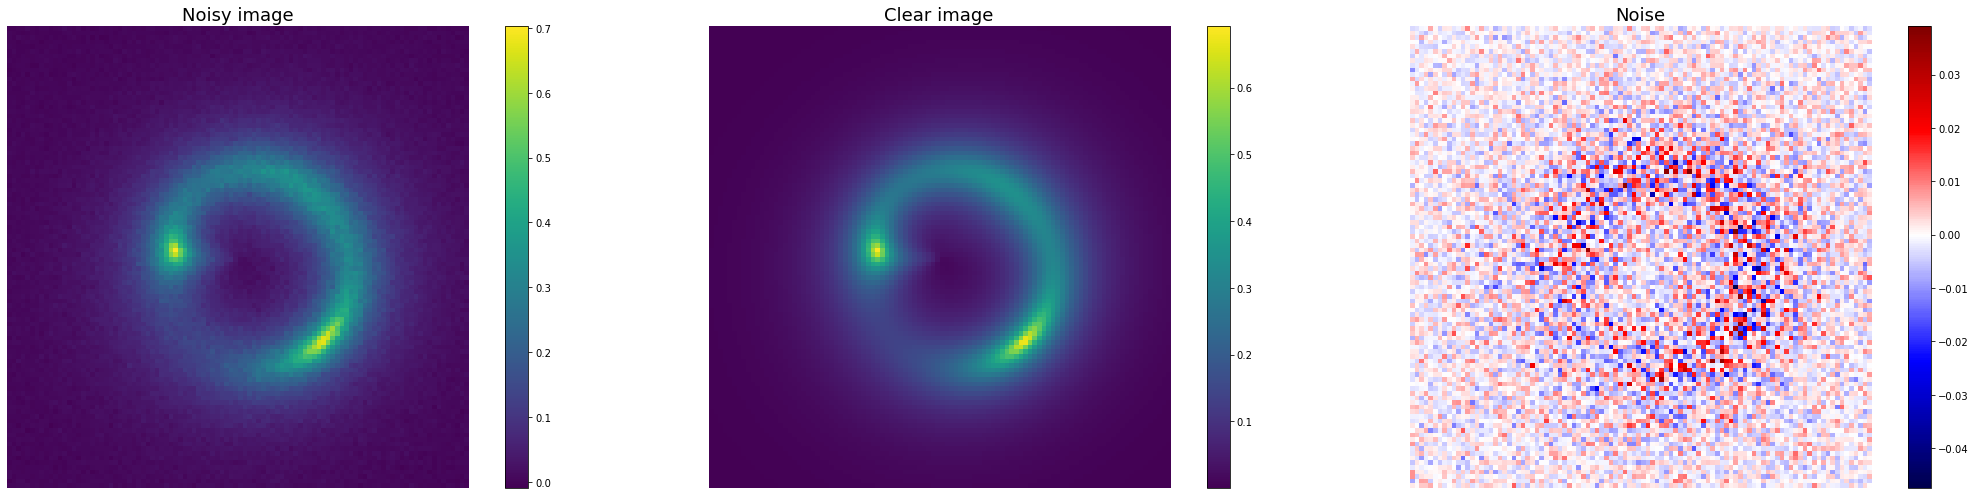

In [3]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)
Image_unperturbed_noisy=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=42)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(Image_unperturbed_noisy)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(Image_unperturbed_noisy-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

## Observed perturbed image

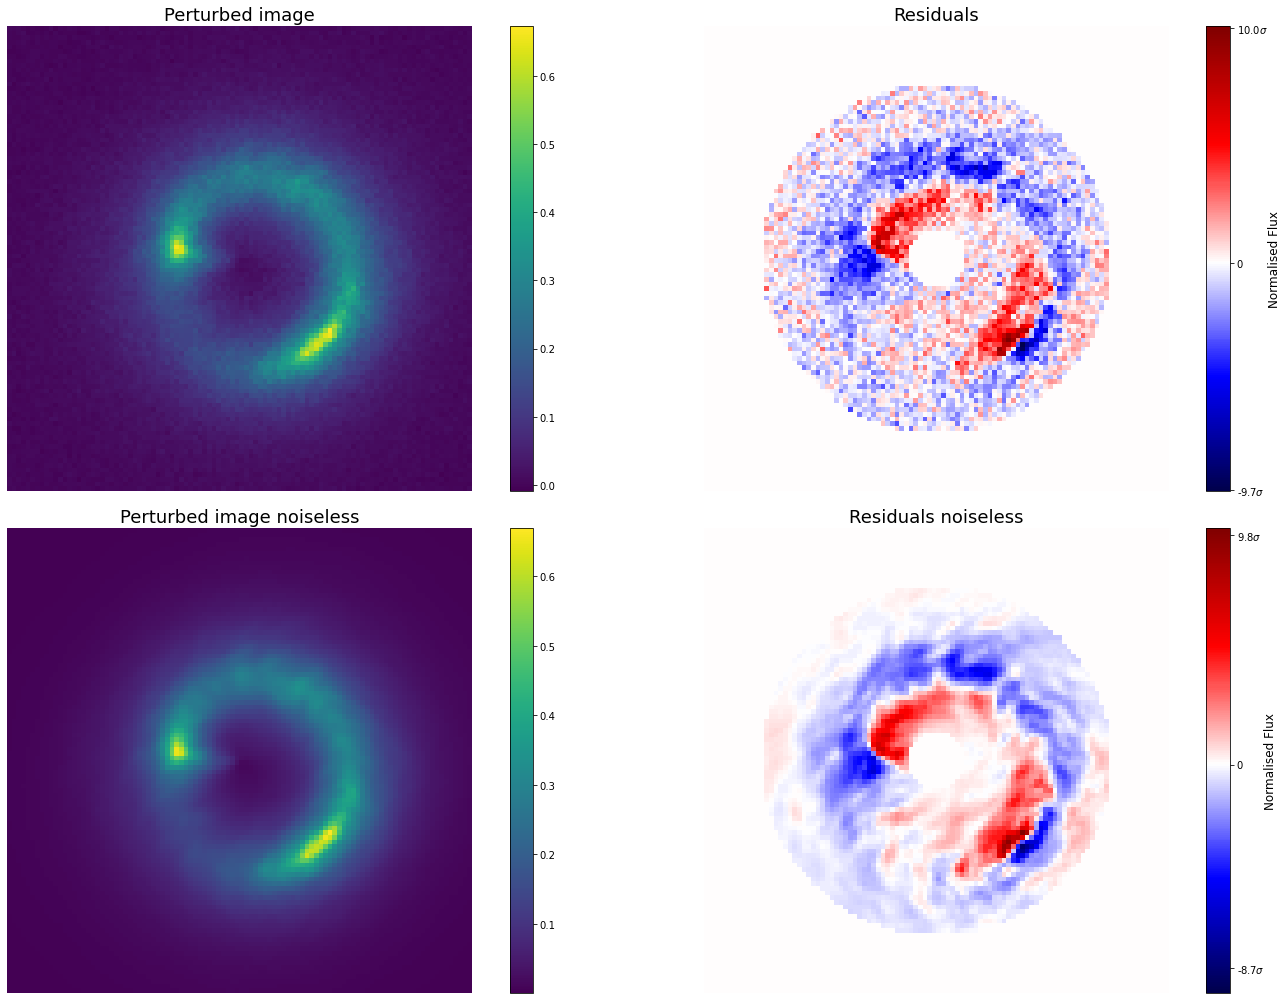

In [4]:
GRF_logA=-7.3
GRF_Beta=4
GRF_seed=1

GRF_params=[GRF_logA,GRF_Beta]

get_GRF=Observation_conditions.GRF_getter
GRF_potential=get_GRF(GRF_params,GRF_seed)
data_noise_seed=np.round(GRF_potential[0,0]*1e+10).astype(int)

simulate_perturbed_image=Observation_conditions.perturbed_image_getter
Image_perturbed_noiseless=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,Noise_flag=False)
Image_perturbed_noisy=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=data_noise_seed)

fig,ax=plt.subplots(2,2,figsize=(20,14))

images=np.array([[Image_perturbed_noisy,Image_perturbed_noisy-Image_unperturbed_noiseless],[Image_perturbed_noiseless,Image_perturbed_noiseless-Image_unperturbed_noiseless]])

#Normalized masked residuals
images[:,1]/=np.sqrt(Observation_conditions.noise_var)
images[:,1]*=Observation_conditions.annulus_mask


titles=np.array([['Perturbed image','Residuals'],['Perturbed image noiseless','Residuals noiseless']])

for i in range(2):
    axis_row=ax[i]
    img_arr=[]
    for j in range(2):
        axis=axis_row[j]
        image=images[i,j]
        title=titles[i,j]
        
        if j==0:
            img=axis.imshow(image)
            fig.colorbar(img,ax=axis)
        else:
            img=axis.imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,images[:,1].min(),images[:,1].max()))
            colorborders=[math.ceil(image.min()*1e+1)/1e+1,0,math.floor(image.max()*1e+1)/1e+1]
    
            cbar=fig.colorbar(img,ax=axis,ticks=colorborders,fraction=0.045)
            cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
            cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    
        axis.set_title(title,fontsize=FS)
        axis.axis('off')
plt.tight_layout()
plt.show()

# Data spectrum extraction

## Fit observed image to infer Source-Lens kwargs

In [5]:
simulate_unperturbed_image_pure=lambda kwargs: simulate_unperturbed_image(kwargs,Noise_flag=False)
parameters=Observation_conditions.parameters

#Fit the data_image with unperturbed lens-source model to get a guess of kwargs_data, since we don't know them initially
#We use scipy fitting with Newton-CG to get as good fit as possible

#'Newton-CG' is unrelibale method. 'trust-krylov' seems good and stabel for different noise conditions
#Eventually scipy.minimize fitting should be replaced by MCM, to be sure that the fit is global minimum (might also try HMC)
kwargs_guess=scipy_fit_image(Image_perturbed_noisy,simulate_unperturbed_image_pure,Observation_conditions.noise_var,parameters,method='trust-krylov')
args_guess=parameters.kwargs2args(kwargs_guess)
fit_image=simulate_unperturbed_image_pure(kwargs_guess)

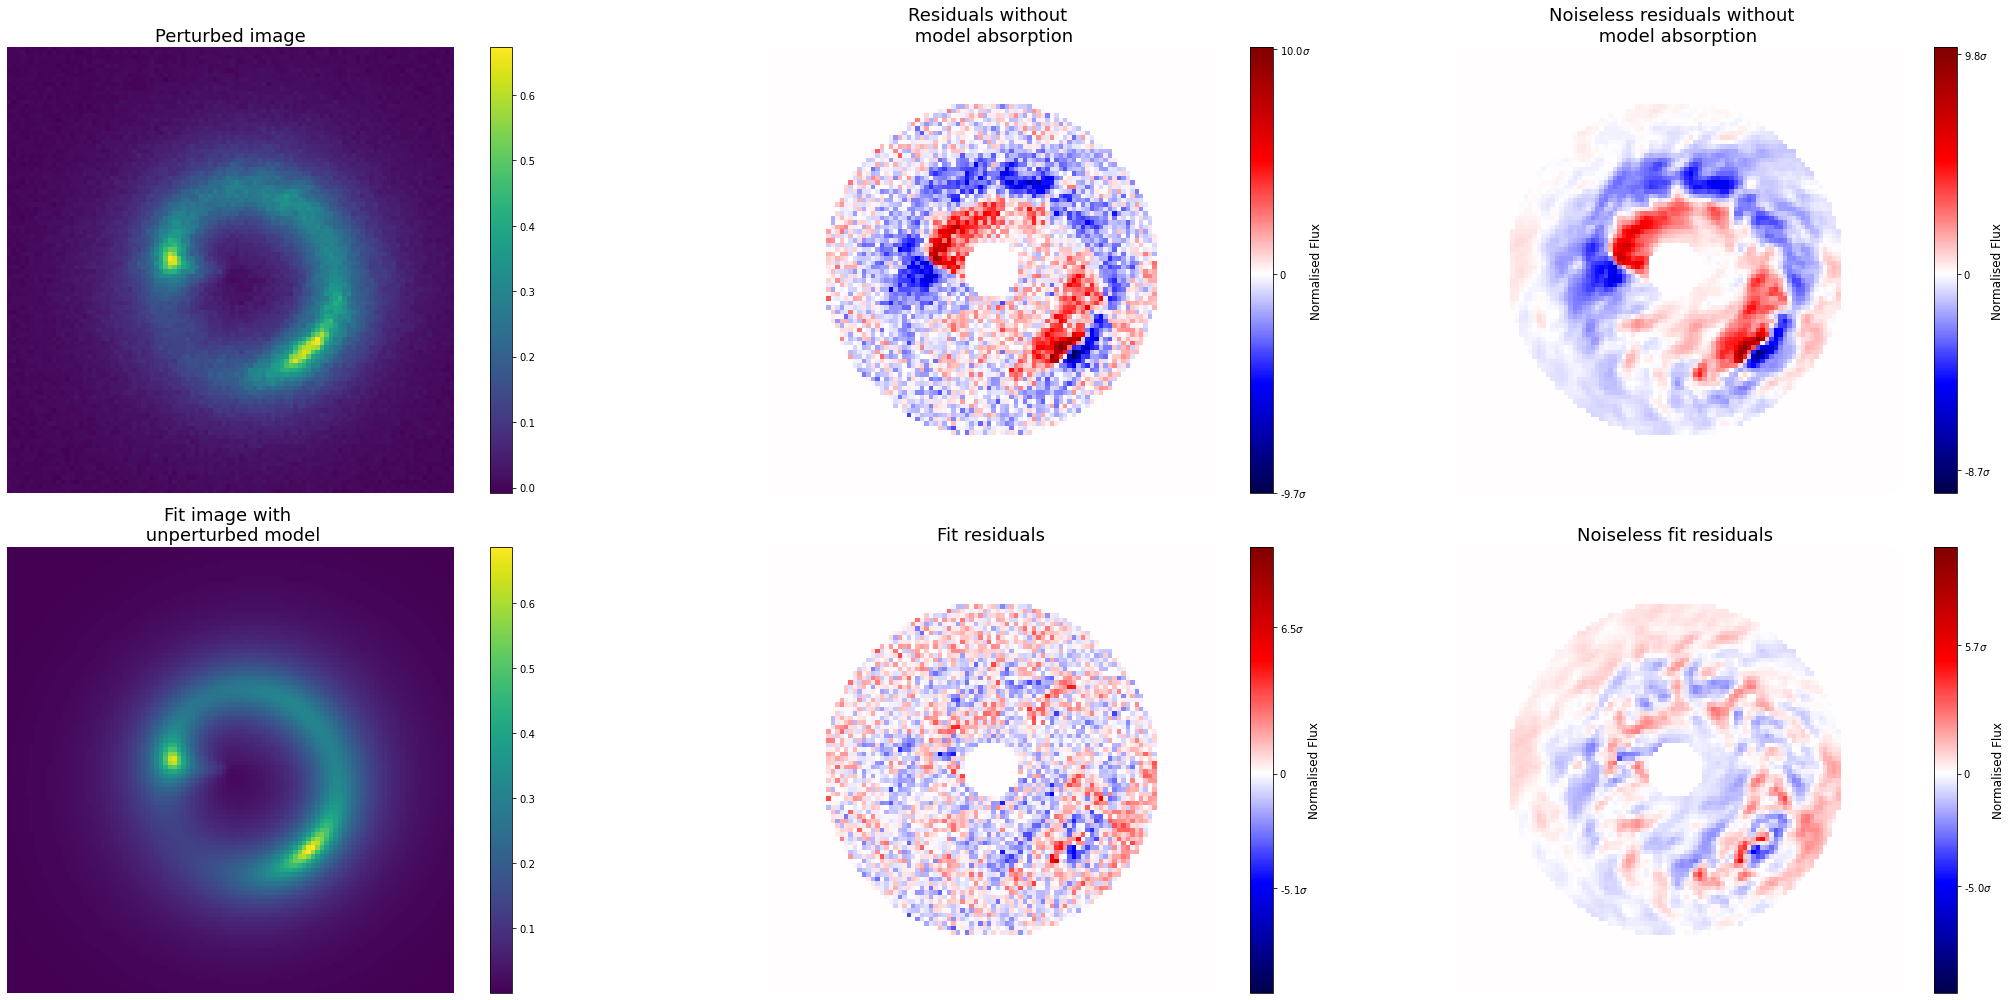

In [6]:
fig,ax=plt.subplots(2,3,figsize=(30,14))

images=np.array([[Image_perturbed_noisy,Image_perturbed_noisy-Image_unperturbed_noiseless,Image_perturbed_noiseless-Image_unperturbed_noiseless],\
                 [fit_image,Image_perturbed_noisy-fit_image,Image_perturbed_noisy-fit_image-(Image_perturbed_noisy-Image_perturbed_noiseless)]])

#Normalized masked residuals
images[:,1:]/=np.sqrt(Observation_conditions.noise_var)
images[:,1:]*=Observation_conditions.annulus_mask


titles=np.array([['Perturbed image','Residuals without \n model absorption','Noiseless residuals without \n model absorption'],\
                 ['Fit image with \n unperturbed model','Fit residuals','Noiseless fit residuals']])

for i in range(2):
    axis_row=ax[i]
    img_arr=[]
    for j in range(3):
        axis=axis_row[j]
        image=images[i,j]
        title=titles[i,j]
        
        if j==0:
            img=axis.imshow(image)
            fig.colorbar(img,ax=axis)
        else:
            img=axis.imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,images[:,1:].min(),images[:,1:].max()))
            colorborders=[math.ceil(image.min()*1e+1)/1e+1,0,math.floor(image.max()*1e+1)/1e+1]
    
            cbar=fig.colorbar(img,ax=axis,ticks=colorborders,fraction=0.045)
            cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
            cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    
        axis.set_title(title,fontsize=FS)
        axis.axis('off')
plt.tight_layout()
plt.show()

## Differentiable fit

In [11]:
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Observation_conditions.annulus_mask,Observation_conditions.init_freq_index)
differentiable_fit_image_pure=purify_function(differentiable_fit_image,simulate_unperturbed_image_pure,args_guess,Observation_conditions.noise_var,parameters,1000,1e-4)

In [12]:
test_dif_fit_image=differentiable_fit_image_pure(Image_perturbed_noisy)

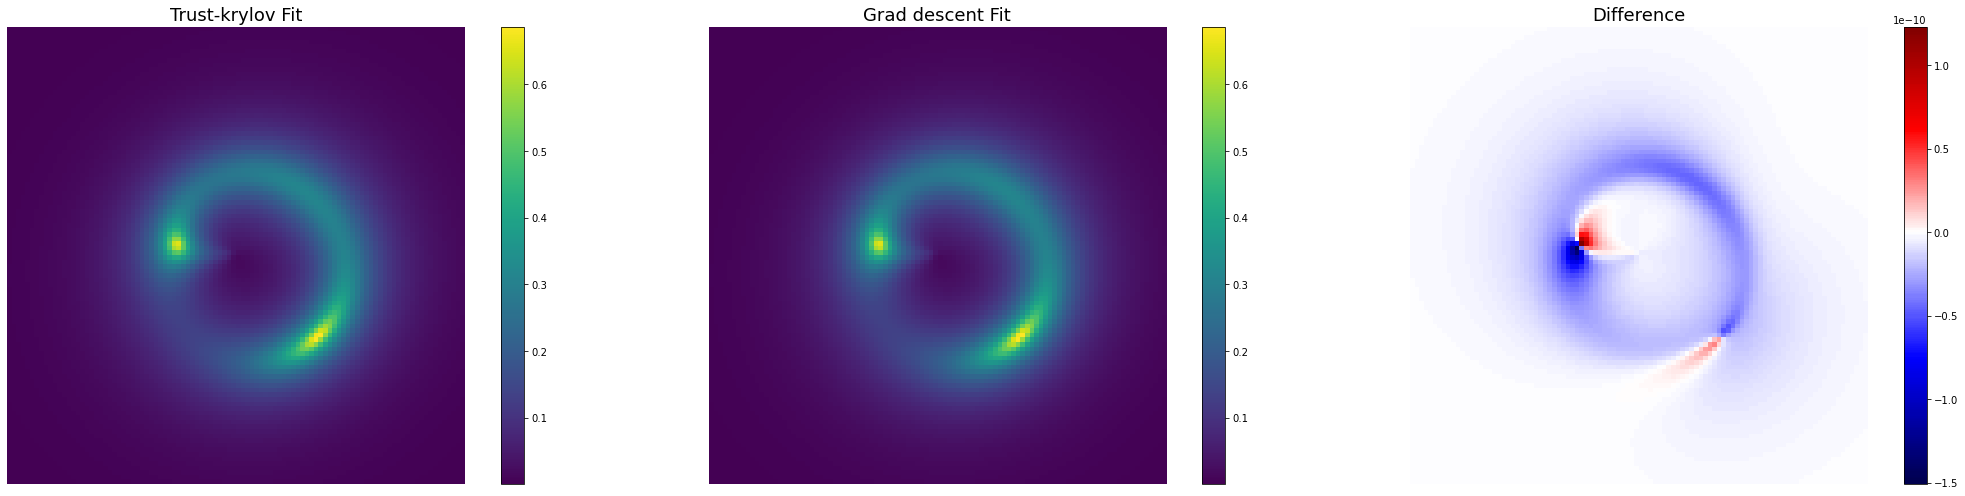

In [13]:
fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(fit_image)]
img_arr+=[ax[1].imshow(test_dif_fit_image)]
img_arr+=[ax[2].imshow(fit_image-test_dif_fit_image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Trust-krylov Fit','Grad descent Fit','Difference']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

# Power spectrum generation

In [17]:
simulate_perturbed_image_pure=lambda GRF_potential,noise_seed: simulate_perturbed_image(GRF_potential,kwargs_guess,True,noise_seed)

def compute_spectrum(logA,Beta,GRF_seed,simulate_perturbed_image_pure,differentiable_fit_image_pure,compute_radial_spectrum_pure):
    GRF_potential=get_GRF([logA,Beta],GRF_seed)
    #We want our noise to not be static in all the computations
    noise_seed=np.round(GRF_potential[0,0]*1e+10).astype(int)
    
    
    simulated_image=simulate_perturbed_image_pure(GRF_potential,noise_seed)
    fit_image=differentiable_fit_image_pure(simulated_image)
    residuals=simulated_image-fit_image
    spectrum=compute_radial_spectrum_pure(residuals)
    return spectrum

def compute_spectrum_pure(logA,Beta,GRF_seed):
    return compute_spectrum(logA,Beta,GRF_seed,simulate_perturbed_image_pure,differentiable_fit_image_pure,compute_radial_spectrum_pure)

In [29]:
true_spectrum=compute_radial_spectrum_pure(Image_perturbed_noisy-fit_image)
true_noise_spectrum=compute_radial_spectrum_pure(Image_perturbed_noisy-Image_perturbed_noiseless)
Guess_spectrum=compute_spectrum_pure(-7.2,3.9,2)

In [67]:
Res_Spectra=np.zeros((300,len(frequencies)))

for i in tqdm(range(300)):
    Res_Spectra[i]=compute_spectrum_pure(GRF_params[0],GRF_params[1],i+1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [05:02<00:00,  1.01s/it]


In [35]:
Noise_spectra=jax_map(compute_radial_spectrum_pure,np.array([np.random.normal(0,np.sqrt(Observation_conditions.noise_var)) for i in tqdm(range(10000))]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3969.54it/s]


In [22]:
Estimated_Noise_spectral_density=(Observation_conditions.noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()
frequencies=Observation_conditions.frequencies

## Spectra distributions

In [36]:
import scipy
def lognormal(xdata,*params):
    amplitude,s,loc,scale=params
    x=(xdata-loc)/scale
    return amplitude*scipy.stats.lognorm.pdf(x,s)

def normal_distr(xdata,*params):
    amplitude,mean,sigma=params
    
    return amplitude*np.exp(-(xdata-mean)**2/2/sigma**2)

def fit_likelihood(xdata,ydata,distr_func='lognormal',multiplier=None,Poisson_errs=False):
    
    #It is a trick to fit distributions in very small numbers here scipy just sets everyrhing to zero
    if multiplier:
        x=multiplier*xdata
    else:
        non_zero_xdata=xdata[np.where(xdata>0)[0]]
        multiplier=1/non_zero_xdata[0]
        x=multiplier*xdata
        
    if distr_func=='lognormal':
        func=lognormal
        init_guess=[1,1.,0.,1]
    elif distr_func=='normal':
        func=normal_distr
        init_guess=[1,x.mean(),x.std()]
    else:
        print('wrong distr_func')
        return None
    
        
    
    if Poisson_errs:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess,sigma=ydata)
    else:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess)

    
    if distr_func=='lognormal':
        amplitude,s,loc,scale=popt
        return amplitude,s,loc/multiplier,scale/multiplier
    if distr_func=='normal':
        amplitude,mean,sigma=popt
        return amplitude,mean/multiplier,sigma/multiplier
    
    
def infer_LogNorm_params(Power_spectrum_maxtrix):
    '''https://digitalcommons.fiu.edu/cgi/viewcontent.cgi?article=1677&context=etd'''
    #Moments of distribution
    mean=jnp.mean(Power_spectrum_maxtrix,axis=0)
    variance=jnp.power(jnp.std(Power_spectrum_maxtrix,axis=0),2)
    median=jnp.median(Power_spectrum_maxtrix,axis=0)
    
    #Parameters of logNormal distribution
    sigma=jnp.sqrt(jnp.log(1+variance/jnp.power(mean,2)))
    mu=jnp.log(mean)-jnp.power(sigma,2)/2
    gamma=jnp.maximum(median-jnp.exp(mu),0)
    
    return gamma,mu,sigma
    

0.0
q


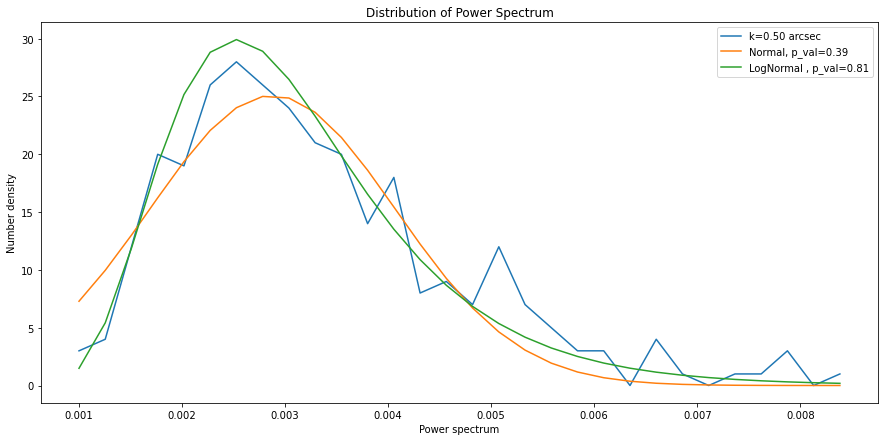

0.0
q


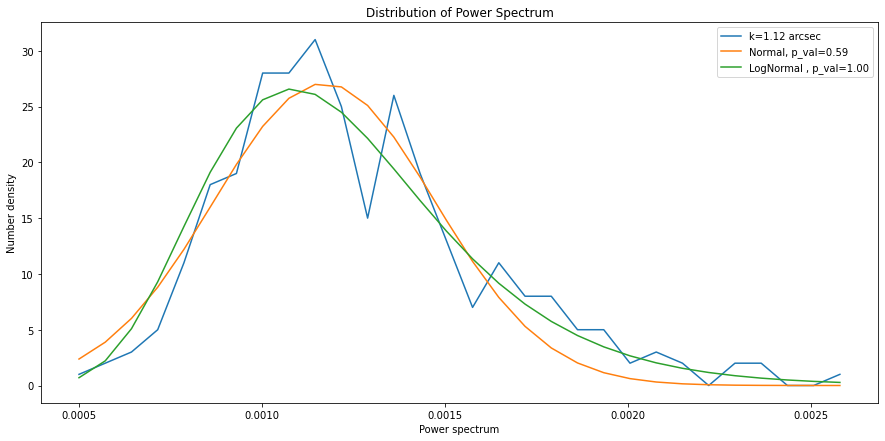

2.489583592585223e-06
q


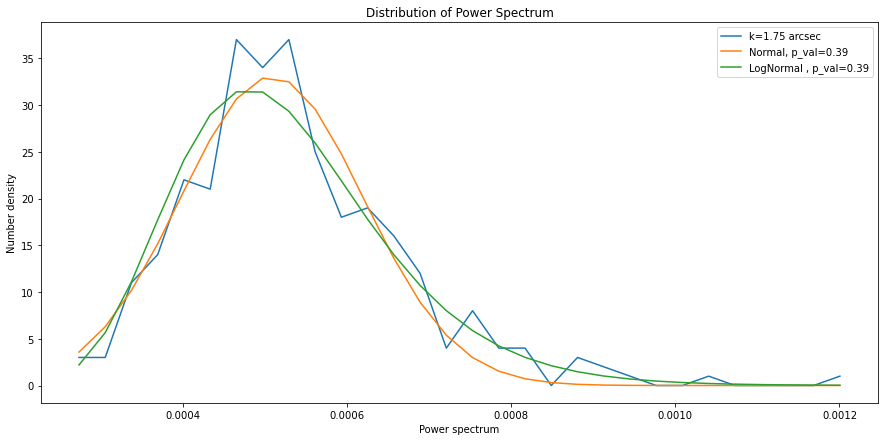

4.353448142345407e-06
q


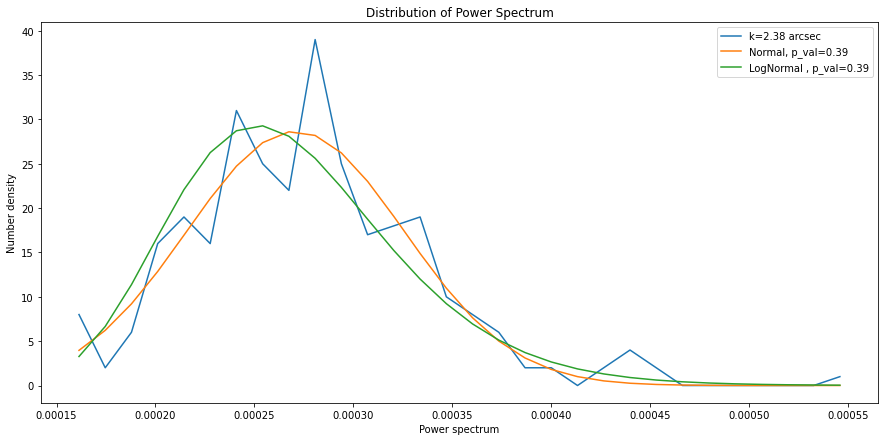

0.0
q


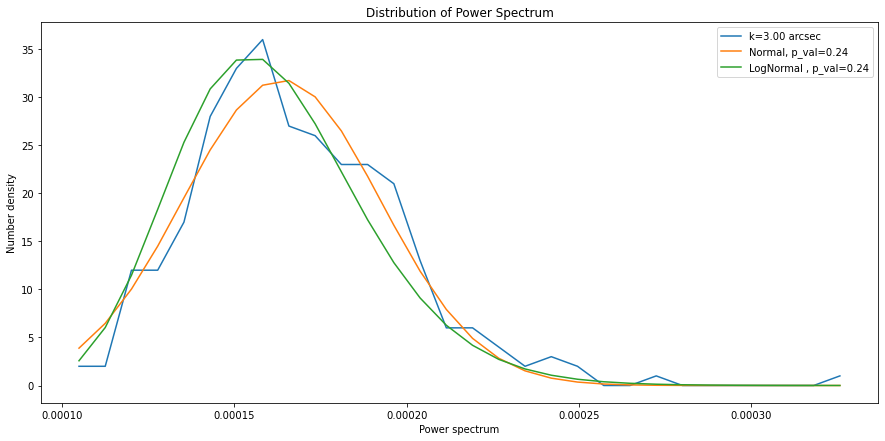

2.2894032221053003e-07
q


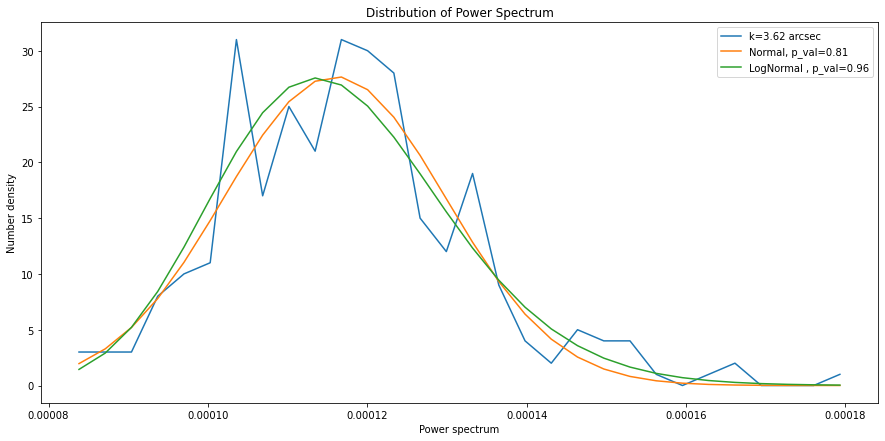

8.000090817675027e-07
q


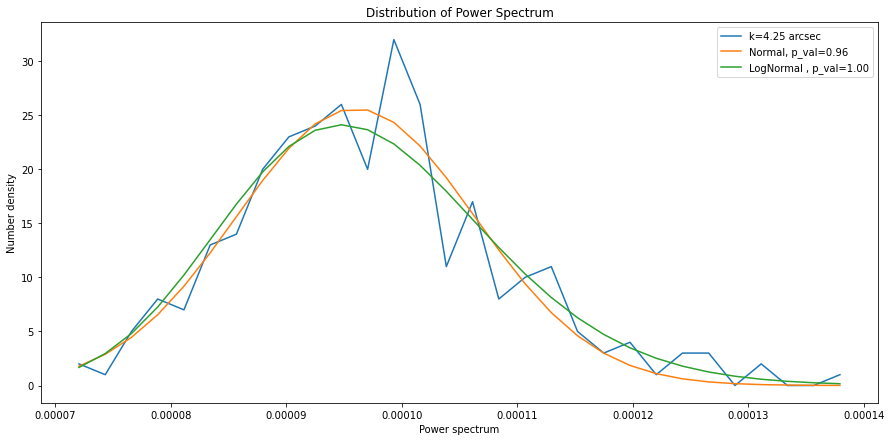

1.7090579856036438e-07
q


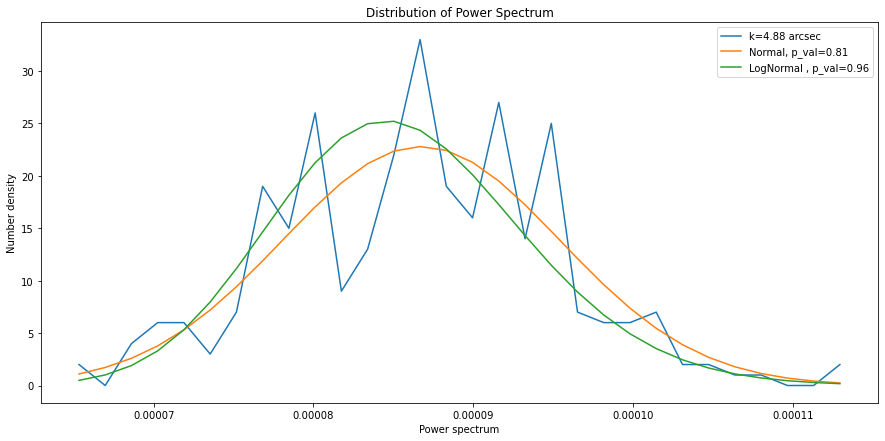

0.0
q


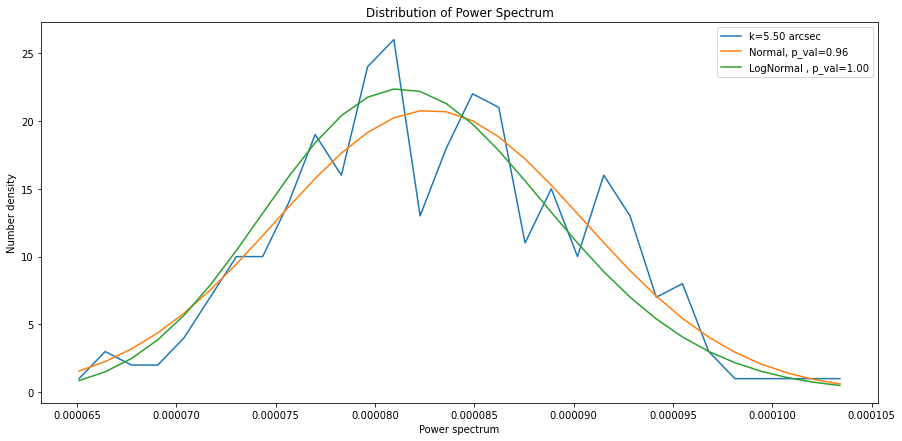

1.0047555040016776e-06
q


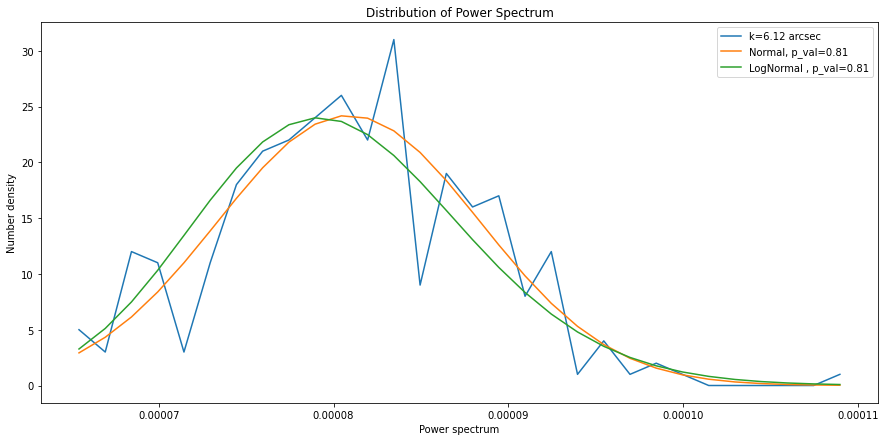

In [68]:
step=5
pval=[]
log_pval=[]

for i in range(0,46,step):
    print(gamma[i])
    fig=plt.figure(figsize=(15,7))
    mean=np.log(Res_Spectra[:,i]).mean()
    std=np.log(Res_Spectra[:,i]).std()
    data,x=np.histogram(Res_Spectra[:,i],bins=30)
    
    
    lognorm_distr=lognormal(x[1:],*[1,sigma[i],0,np.exp(mu[i])])
    lognorm_distr/=lognorm_distr.sum()
    lognorm_distr*=data.sum()
    
    try:
        popt=fit_likelihood(x[1:],data,distr_func='normal',Poisson_errs=False)
        norm_distr=normal_distr(x[1:],*popt)
        print('q')
    except:
        norm_distr=np.exp(-((x[1:]-x[1:].mean())**2)/2/x[1:].std()**2)
        norm_distr/=norm_distr.sum()
        norm_distr*=data.sum()
    
    
    
    
    plt.plot(x[1:],data,label='k={:.2f} arcsec'.format(frequencies[i]))
    plt.plot(x[1:],norm_distr,label='Normal, p_val={:.2f}'.format(scipy.stats.ks_2samp(data,norm_distr)[1]))
    plt.plot(x[1:],lognorm_distr,label='LogNormal , p_val={:.2f}'.format(scipy.stats.ks_2samp(data,lognorm_distr)[1]))
    plt.legend()
    plt.ylabel('Number density')
    plt.xlabel('Power spectrum')
    plt.title('Distribution of Power Spectrum')
    plt.show()
    

for i in range(len(pval)):
    print('LogNorm p_val={:.2f}, Norm p_val={:.2f}, '.format(log_pval[i],pval[i]))

In [70]:
Ngamma,Nmu,Nsigma=infer_LogNorm_params(Noise_spectra)

0.0
q


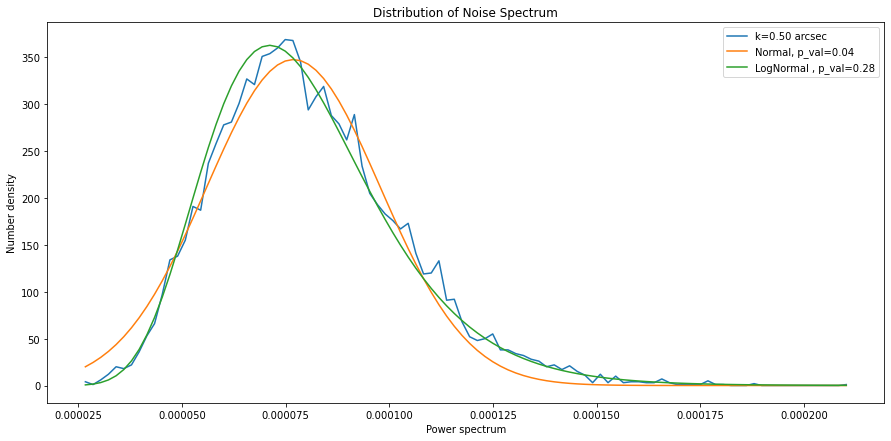

0.0
q


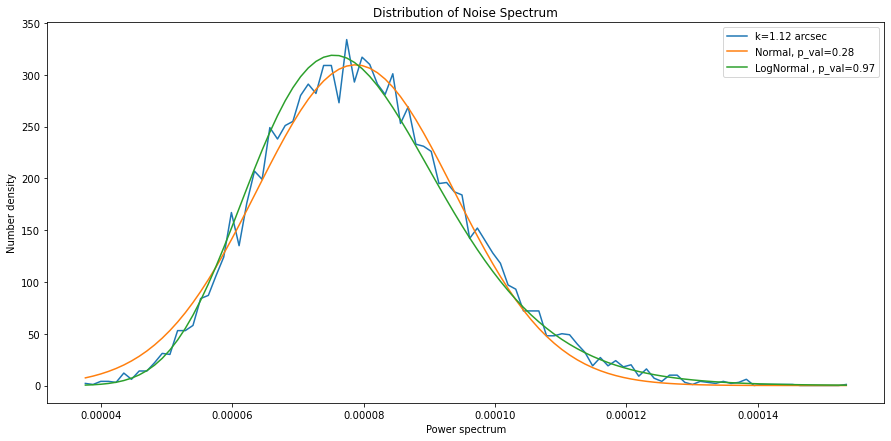

2.489583592585223e-06
q


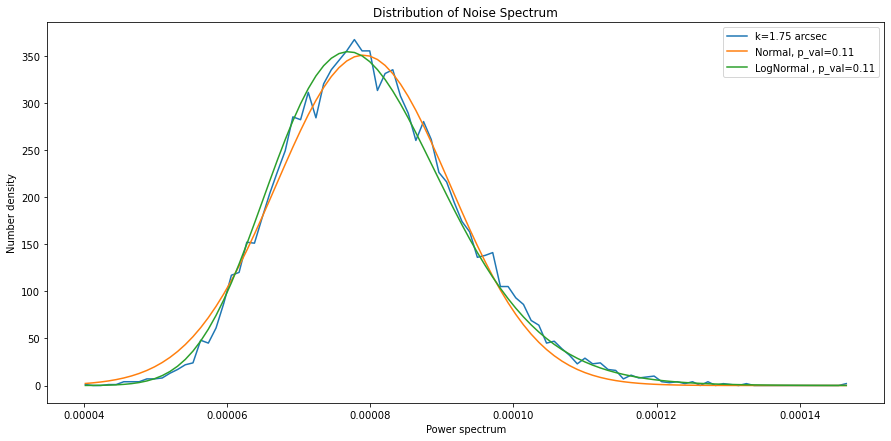

4.353448142345407e-06
q


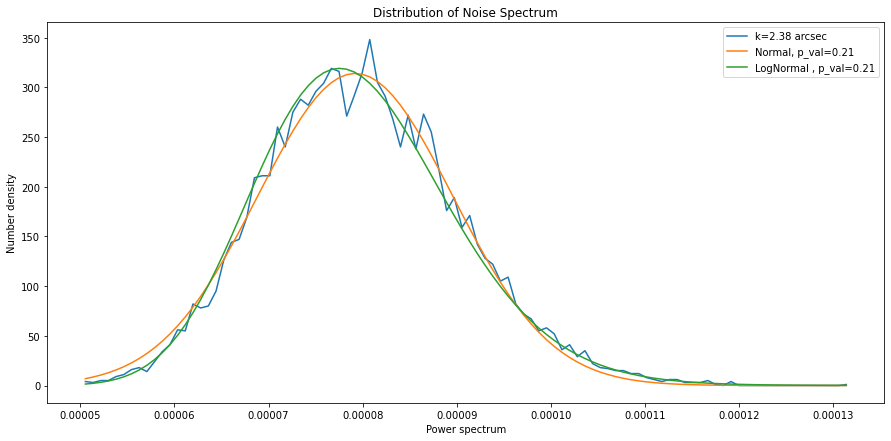

0.0
q


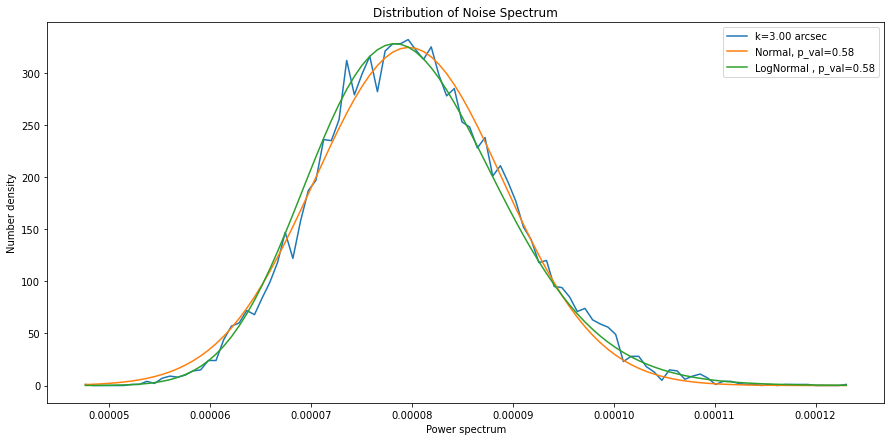

2.2894032221053003e-07
q


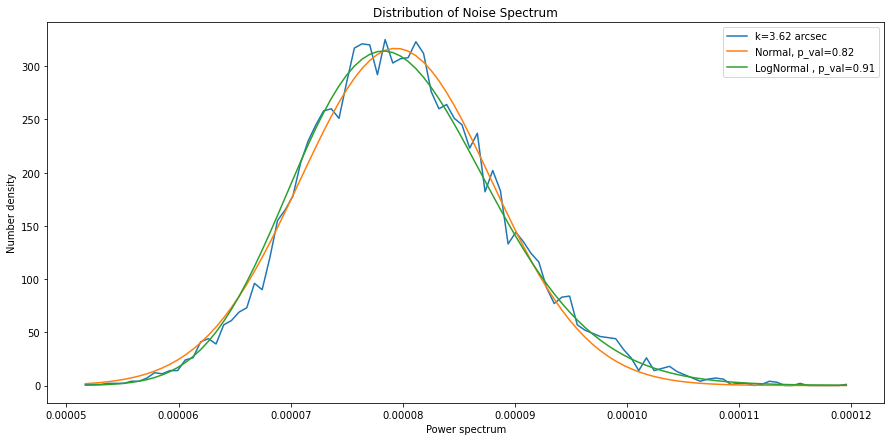

8.000090817675027e-07
q


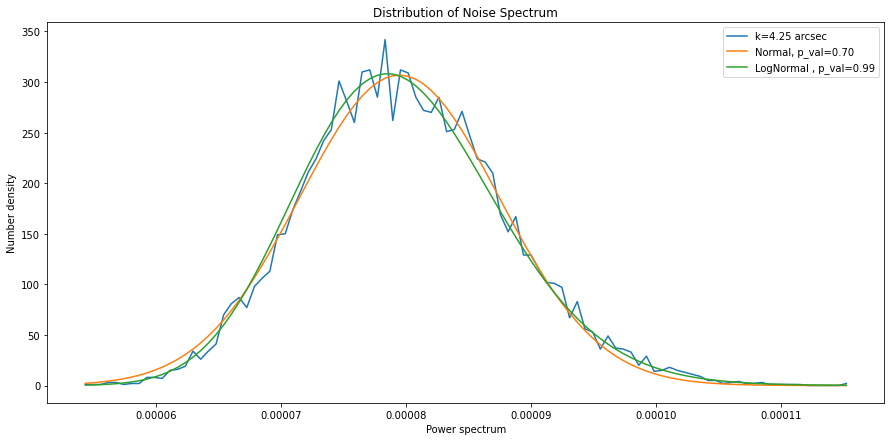

1.7090579856036438e-07
q


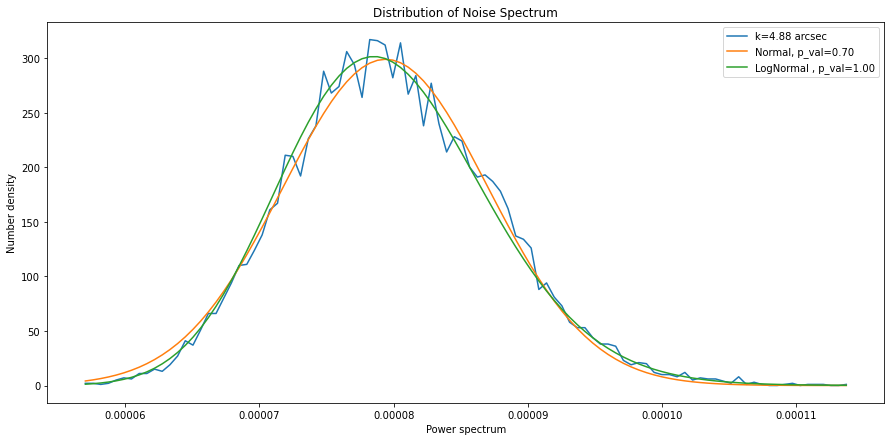

0.0
q


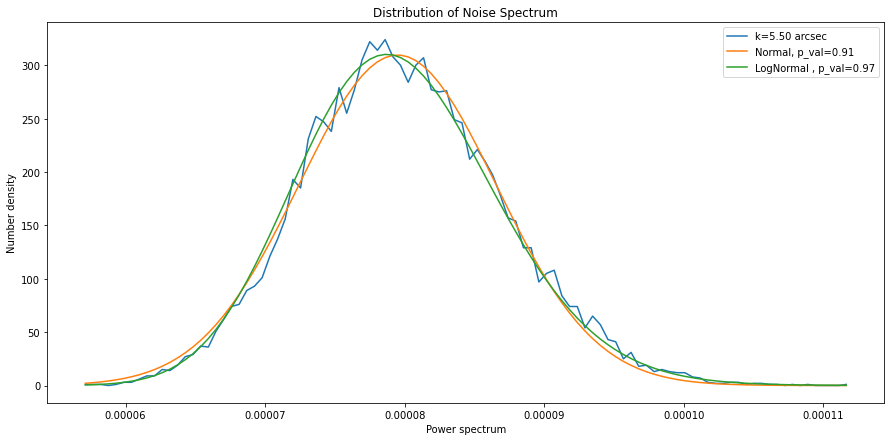

1.0047555040016776e-06
q


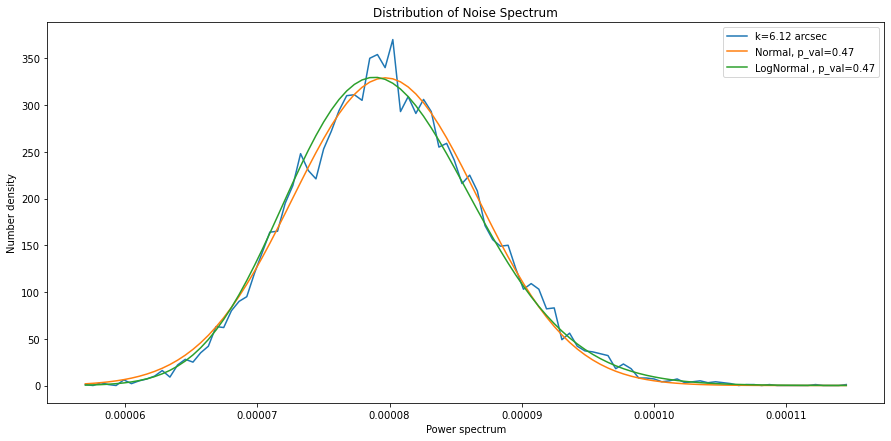

In [60]:
step=5
pval=[]
log_pval=[]

for i in range(0,46,step):
    print(gamma[i])
    fig=plt.figure(figsize=(15,7))
    mean=np.log(Res_Spectra[:,i]).mean()
    std=np.log(Res_Spectra[:,i]).std()
    data,x=np.histogram(Noise_spectra[:,i],bins=100)
    
    
    lognorm_distr=lognormal(x[1:],*[1,Nsigma[i],0,np.exp(Nmu[i])])
    lognorm_distr/=lognorm_distr.sum()
    lognorm_distr*=data.sum()
    
    try:
        popt=fit_likelihood(x[1:],data,distr_func='normal',Poisson_errs=False)
        norm_distr=normal_distr(x[1:],*popt)
        print('q')
    except:
        norm_distr=np.exp(-((x[1:]-x[1:].mean())**2)/2/x[1:].std()**2)
        norm_distr/=norm_distr.sum()
        norm_distr*=data.sum()
    
    
    
    
    plt.plot(x[1:],data,label='k={:.2f} arcsec'.format(frequencies[i]))
    plt.plot(x[1:],norm_distr,label='Normal, p_val={:.2f}'.format(scipy.stats.ks_2samp(data,norm_distr)[1]))
    plt.plot(x[1:],lognorm_distr,label='LogNormal , p_val={:.2f}'.format(scipy.stats.ks_2samp(data,lognorm_distr)[1]))
    plt.legend()
    plt.ylabel('Number density')
    plt.xlabel('Power spectrum')
    plt.title('Distribution of Noise Spectrum')
    plt.show()
    

for i in range(len(pval)):
    print('LogNorm p_val={:.2f}, Norm p_val={:.2f}, '.format(log_pval[i],pval[i]))

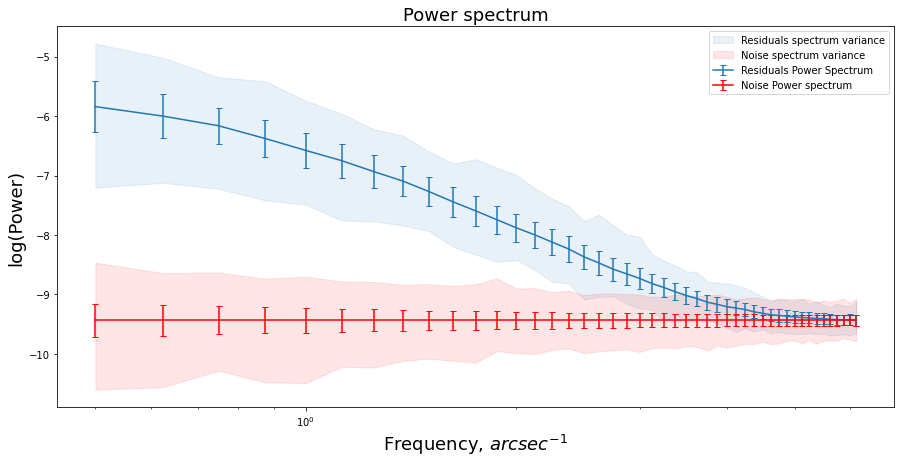

In [73]:
plt.figure(figsize=(15,7))
#plt.plot(masked_k_vector,data_resid_spectrum,label='Target',color='k')

mean_Spec=np.log(Res_Spectra).mean(axis=0)
logSpec_uncertainty=np.log(Res_Spectra).std(axis=0)
#Phase_uncertainty=[np.exp(mean_Spec-logPhase_uncertainty),np.exp(mean_Spec+logPhase_uncertainty)]

#plt.plot(frequencies,np.log(true_spectrum),label='Data spectrum',color='k')
plt.errorbar(frequencies,mean_Spec,logSpec_uncertainty,capsize=3,label='Residuals Power Spectrum',color='C0')
plt.fill_between(frequencies,np.log(Res_Spectra.min(axis=0)),np.log(Res_Spectra.max(axis=0)),color='C0',alpha=0.1,label='Residuals spectrum variance')

logNoise_uncertainty=np.log(Noise_spectra).std(axis=0)
plt.fill_between(frequencies,np.log(Noise_spectra).min(axis=0),np.log(Noise_spectra).max(axis=0),color='r',alpha=0.1,label='Noise spectrum variance')
plt.errorbar(frequencies,np.log(Estimated_Noise_spectral_density)*np.ones_like(frequencies),logNoise_uncertainty,capsize=3,label='Noise Power spectrum',color='r')




plt.xscale('log')
#plt.yscale('log')

plt.ylabel('log(Power)',fontsize=FS)
plt.xlabel('Frequency, '+r'$arcsec^{-1}$',fontsize=FS)
plt.title('Power spectrum',fontsize=FS)


plt.legend()
plt.show()

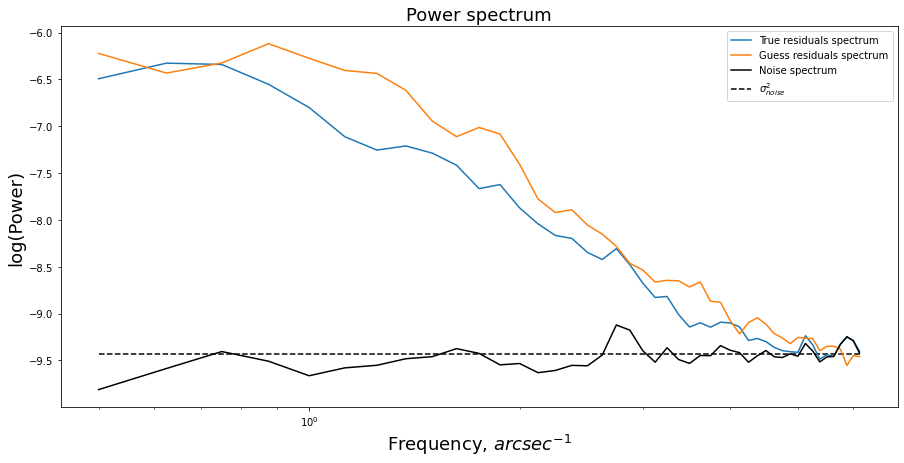

In [43]:
plt.figure(figsize=(15,7))

plt.plot(frequencies,np.log(true_spectrum),label='True residuals spectrum')
plt.plot(frequencies,np.log(Guess_spectrum),label='Guess residuals spectrum')
plt.plot(frequencies,np.log(true_noise_spectrum),label='Noise spectrum',color='k')
plt.hlines(np.log(Estimated_Noise_spectral_density),frequencies[0],frequencies[-1],label=r'$\sigma^2_{noise}$',color='k',linestyle='--')


plt.xscale('log')

plt.ylabel('log(Power)',fontsize=FS)
plt.xlabel('Frequency, '+r'$arcsec^{-1}$',fontsize=FS)
plt.title('Power spectrum',fontsize=FS)

plt.legend()
plt.show()

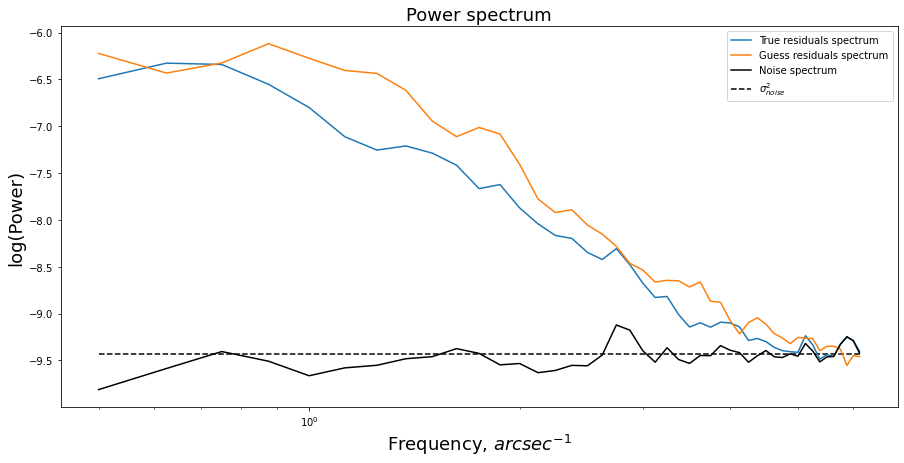

In [33]:
plt.figure(figsize=(15,7))

plt.plot(frequencies,np.log(true_spectrum),label='True residuals spectrum')
plt.plot(frequencies,np.log(Guess_spectrum),label='Guess residuals spectrum')
plt.plot(frequencies,np.log(true_noise_spectrum),label='Noise spectrum',color='k')
plt.hlines(np.log(Estimated_Noise_spectral_density),frequencies[0],frequencies[-1],label=r'$\sigma^2_{noise}$',color='k',linestyle='--')


plt.xscale('log')

plt.ylabel('log(Power)',fontsize=FS)
plt.xlabel('Frequency, '+r'$arcsec^{-1}$',fontsize=FS)
plt.title('Power spectrum',fontsize=FS)

plt.legend()
plt.show()